# CYCLOPS on Mouse Liver Data (Boxplot: Sparse PCA)

## 1. Importing packages

In [1]:
from cyclops_v2 import *
from spca import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Loading data

Read the Mouse Liver data into a pandas dataframe:

In [2]:
df = pd.read_csv("mouseLiver.csv").T
df = df.iloc[1:,:]

In [3]:
ng = df.shape[1]
nc = df.shape[0]
print("Running on {} genes and {} cells.".format(ng,nc))

Running on 14312 genes and 48 cells.


## 3. Data Preprocessing

Filter and sort genes in descending order of variance:

In [4]:
frac = 1.00

df_std = pd.DataFrame(df.std().sort_values(ascending=False))
df_std = df_std.iloc[:round(df_std.shape[0]*frac),:]
df_std.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14312 entries, 4414 to 146
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       14312 non-null  float64
dtypes: float64(1)
memory usage: 223.6 KB


In [5]:
gene_list = df_std.index.to_numpy()
gene_list;

In [6]:
data = df.to_numpy().T

newdata = np.zeros([len(gene_list),nc])
for i in range(len(gene_list)):
    newdata[i] = data[gene_list[i]]
newdata = pd.DataFrame(newdata.T)
newdata.shape

(48, 14312)

Before performing dimensionality reduction, the dataset has to be __centered__ to zero mean:

In [7]:
df_cent = newdata.transform(lambda x: x-x.mean())
df_cent.head()

,0,1,2,3,4,5,6,7,8,9,...,14302,14303,14304,14305,14306,14307,14308,14309,14310,14311
0,-1.074904,-1.346862,-0.435143,0.581335,0.291266,-0.404934,-0.572699,-0.080760,-0.366932,0.833576,...,0.041128,-0.031751,-0.024382,-0.031903,-0.009015,-0.012072,0.053372,-0.013453,0.000146,0.038209
1,-1.325239,-1.478688,-0.945180,-0.105732,0.199204,-0.312123,-0.350296,-0.312390,-0.287158,0.804969,...,-0.013596,-0.044556,0.037694,-0.049372,-0.034169,-0.042825,-0.026114,-0.019841,0.028850,0.027483
2,-1.467395,-1.152329,-0.665212,0.202131,0.111784,-0.396584,-0.252562,0.372546,-0.382673,0.879127,...,0.021382,-0.035407,0.084209,-0.020760,-0.001642,-0.027141,0.000635,-0.043749,0.028964,0.008027
3,-1.796292,-1.381943,-0.281816,-0.385229,-0.180603,-0.444568,-0.191849,-0.311879,-0.344652,0.879681,...,0.020232,0.030110,0.072721,0.013116,0.044191,-0.016357,-0.010383,-0.014354,0.008147,0.009505
4,-1.986607,-1.288099,-1.167620,-1.071924,-0.228164,-0.524226,-0.173404,-0.820587,-0.269711,0.805292,...,0.026128,-0.007750,-0.035430,-0.015456,0.060803,-0.066397,0.025762,-0.028815,0.043894,-0.001865


## Karthik's SPCA

#### Convert the dataframe to a numpy array:

In [8]:
data_ = df_cent.to_numpy()

#### _t_ controls alpha, _ rank_ controls n_components

In [9]:
n_components = 9
alpha = 8
test = rank_n_o(data_, t=alpha, tol=10e-4, rank=n_components)

In [10]:
for k, v in test.items():
    if k=='XV':
        spca_eigengenes = pd.DataFrame(v)
    if k=='V':
        loading_vectors = pd.DataFrame(v)

#### Loading vectors:

In [11]:
loading_vectors = loading_vectors[(loading_vectors.select_dtypes(include=['number']) != 0).any(1)]
loading_vectors.head()

,0,1,2,3,4,5,6,7,8
0,-0.419060,0.257836,0.001976,0.000000,0.000000,0.000013,0.000000,-0.006596,0.000000
1,-0.149924,0.000000,-0.141308,0.000000,0.000000,0.000000,0.793636,0.349556,-0.100514
2,0.000000,0.000000,-0.345339,0.000000,0.000000,0.000000,-0.047312,0.000000,0.000000
3,-0.230702,-0.142014,0.032572,0.165636,0.000000,-0.021241,0.000000,0.000000,0.000000
4,-0.235055,0.000000,0.018027,0.320000,-0.023415,0.000000,0.000000,-0.027689,0.032919


#### Eigengenes:

In [12]:
spca_eigengenes.head()

,0,1,2,3,4,5,6,7,8
0,3.117755,-3.097967,2.746518,3.410521,0.612851,1.642486,-0.369807,-3.460714,0.269942
1,4.226000,-2.288716,2.468850,2.769253,-1.008747,1.614207,0.596717,-2.322534,0.162933
2,4.067920,-1.510597,2.082703,2.496664,-2.948318,0.599094,1.165674,-2.520820,0.486590
3,5.282430,0.212084,1.317687,2.136766,-2.303743,2.288534,1.518398,-2.872609,0.150257
4,5.412072,0.038359,2.295994,2.876256,-4.403611,0.995843,-1.174565,1.712654,0.182412


__Clip__ the values in each eigengene to deal with outliers:

In [13]:
spca_eigengenes = spca_eigengenes.clip(np.percentile(spca_eigengenes, 5, axis=0), np.percentile(spca_eigengenes, 95, axis=0), axis=1)
spca_eigengenes.head()

,0,1,2,3,4,5,6,7,8
0,3.117755,-3.097967,2.563646,2.673847,0.612851,1.642486,-0.369807,-2.618939,0.269942
1,4.226000,-2.288716,2.468850,2.673847,-1.008747,1.614207,0.596717,-2.322534,0.162933
2,4.067920,-1.510597,2.082703,2.496664,-2.869942,0.599094,1.165674,-2.520820,0.486590
3,5.282430,0.212084,1.317687,2.136766,-2.303743,2.288534,1.518398,-2.618939,0.150257
4,5.412072,0.038359,2.295994,2.673847,-2.869942,0.995843,-1.174565,1.712654,0.182412


Sort the eigengenes in descending order of variance:

In [14]:
eig_std = np.array(spca_eigengenes.std().sort_values(ascending=False).index)
eig_std

array([0, 1, 3, 5, 4, 7, 6, 2, 8])

Reorder the columns of the dataframe in descending order of variance:

In [15]:
spca_eigengenes = spca_eigengenes[eig_std]

Plot the three eigengenes with the largest variance:

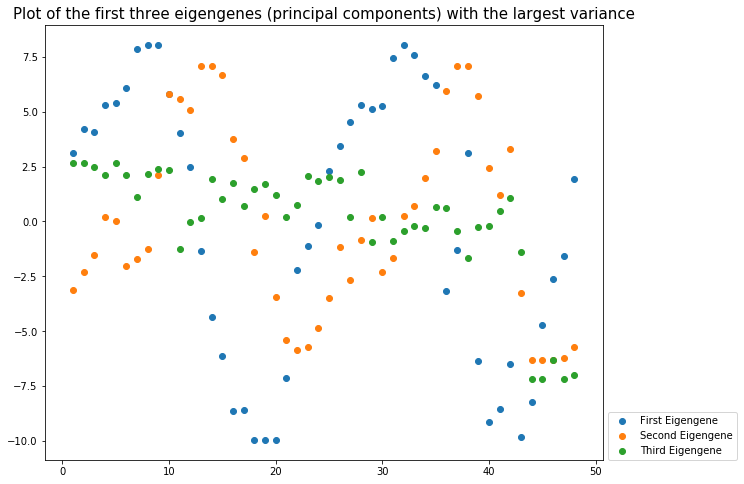

In [16]:
times = np.linspace(1,nc,nc)

eg1 = spca_eigengenes.iloc[:,0]
eg2 = spca_eigengenes.iloc[:,1]
eg3 = spca_eigengenes.iloc[:,2]

plt.figure(figsize=(10,8))
plt.scatter(times, eg1, label="First Eigengene")
plt.scatter(times, eg2, label="Second Eigengene")
plt.scatter(times, eg3, label="Third Eigengene")
plt.title('Plot of the first three eigengenes (principal components) with the largest variance', size=15)
plt.legend(loc=[1.01,0])
plt.show()

Next, plot these three eigengenes against each other:

Text(0.5, 1.0, '2nd vs 3rd')

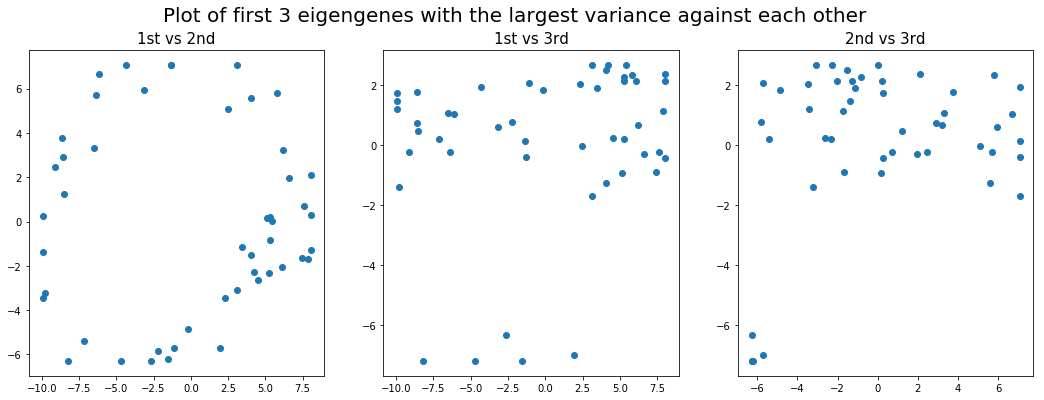

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,6))
plt.suptitle('Plot of first 3 eigengenes with the largest variance against each other', size=20)

ax1.scatter(eg1, eg2)
ax1.set_title('1st vs 2nd', size=15)
ax2.scatter(eg1, eg3)
ax2.set_title('1st vs 3rd', size=15)
ax3.scatter(eg2, eg3)
ax3.set_title('2nd vs 3rd', size=15)

## 4. Creating the autoencoder model

In [18]:
data = spca_eigengenes.to_numpy()

In [19]:
def jump_control(X):
    X_ = X.copy()
    pop_list = []
    for i in range(1,len(X)):
        if X[i]-X[i-1]<10:
            pop_list.append(i)
    pop_list.sort(reverse=True)
    for i in pop_list:
        X_.pop(i)
    return X_

def iterr(data):
    model = cyclops(data.shape[1])
    n_epochs = 500
    history = model.train(data[np.random.permutation(data.shape[0]), :], epochs=n_epochs, verbose=n_epochs, batch_size=10)

    loss = history.history['loss'][-1]
    
    phase_df = model.phase_output(data)
    phase_idx = phase_df.index.to_numpy()
    phase_list = phase_df.pseudotime.to_numpy()
    
    zipped = list(zip(phase_idx,phase_list))
    re_phase_list = np.array([sorted(zipped, key = lambda t: t[0])[i][1] for i in range(len(zipped))])
    re_phase_idx = np.array([sorted(zipped, key = lambda t: t[0])[i][0] for i in range(len(zipped))])
    
    asc_phase_jump, desc_phase_jump = [],[]
    for i in range(len(re_phase_list)-1):
        if re_phase_list[i+1]-re_phase_list[i] > np.pi:
            desc_phase_jump.append(i)
        elif re_phase_list[i+1]-re_phase_list[i] < -np.pi:
            asc_phase_jump.append(i)
            
    if len(asc_phase_jump) > len(desc_phase_jump):
        phase_jump = asc_phase_jump
    else:
        phase_jump = desc_phase_jump


    phase_jump = jump_control(phase_jump)

    jumps = len(phase_jump)
    for i in range(jumps):
        if len(asc_phase_jump) > len(desc_phase_jump):
            re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] + 2*np.pi for i in range(len(zipped))])
        else:
            re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] - 2*np.pi for i in range(len(zipped))])
        phase_jump.pop(0)
    
    from scipy.stats import linregress

    lin = linregress(re_phase_idx, re_phase_list)
    
    r_squared = lin[2]**2
    
    return loss, r_squared

In [20]:
%%capture
%%time

n_iter = 50

iter_list = np.zeros([n_iter,2])

for i in range(n_iter):
    iter_list[i] = iterr(data)

In [21]:
cs = np.array([iter_list[i][0] for i in range(len(iter_list))])
r2 = np.array([iter_list[i][1] for i in range(len(iter_list))])

/Users/henrylim/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


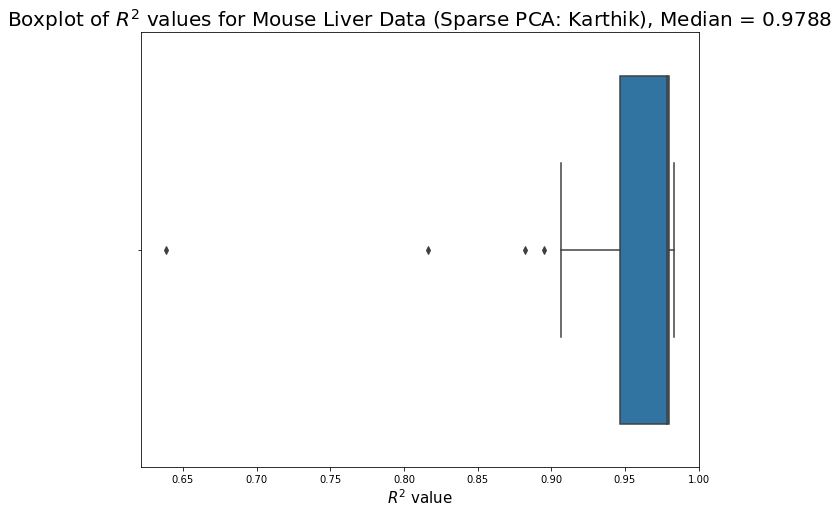

In [22]:
import seaborn as sns
import statistics

plt.figure(figsize=(10,8))
sns.boxplot(r2)
plt.xlabel(r'$R^2$ value', size=15)
plt.title(r'Boxplot of $R^2$ values for Mouse Liver Data (Sparse PCA: Karthik), Median = {:.4f}'.format(statistics.median(r2)), size=20)
plt.show()